# ORENIST Convolutional Filter Example

Note: This notebook is desinged to run with CPU (no GPU) runtime.

####[OCF-01]
Import modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models

####[OCF-02]
Download the ORENIST dataset and store into NumPy arrays.

In [2]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0   738k      0 --:--:-- --:--:-- --:--:--  738k


####[OCF-03]
Show some examples.

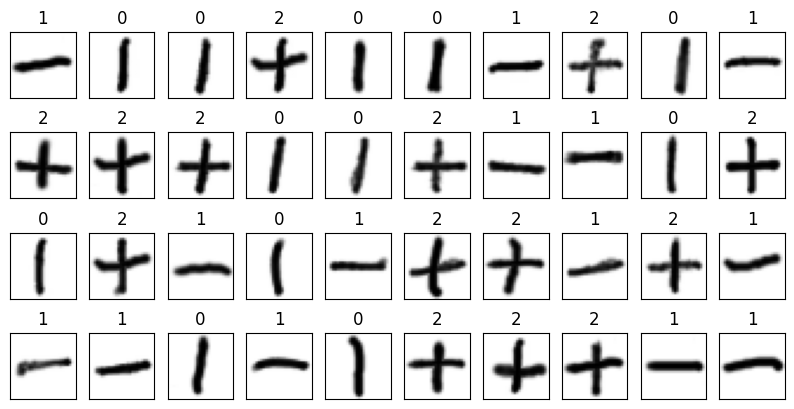

In [3]:
fig = plt.figure(figsize=(10, 5))
for i in range(40):
    subplot = fig.add_subplot(4, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape(28, 28),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

####[OCF-04]
Define fixed convolutional filters to extract vertical and horizontal edges.

In [4]:
def edge_filter(shape=None, dtype=None):
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0

    filter_array = np.zeros([5, 5, 1, 2])
    filter_array[:, :, 0, 0] = filter0
    filter_array[:, :, 0, 1] = filter1

    return filter_array

####[OCF-05]
Define a model to apply the fixed convolutional filters.

In [5]:
model = models.Sequential(name='edge_filter_model')
model.add(layers.Input(shape=(28*28,), name='input'))
model.add(layers.Reshape((28, 28, 1), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=edge_filter,
                        use_bias=False, name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling'))

model.summary()

Model: "edge_filter_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 28, 28, 2)           │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ abs (Lambda)                         │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cut_off (Lambda)                     │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling (MaxPooling2D)           │ (None, 14, 14, 2)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50 (200.00 B)

 Trainable params: 50 (200.00 B)

 Non-trainable params: 0 (0.00 B)

####[OCF-06]
Define a model to extract outputs from intermediate layers.

In [6]:
layer_outputs = [model.get_layer('cut_off').output,
                 model.get_layer('max_pooling').output]
model2 = models.Model(inputs=model.inputs[0], outputs=layer_outputs)

####[OCF-07]
Apply the convolutional filters to the ORENST dataset.

In [7]:
conv_output, pool_output = model2.predict(np.array(images[:9]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


####[OCF-08]
Show images after applying the convolutional filters.

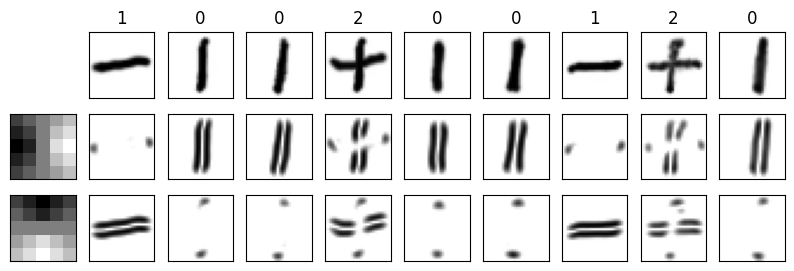

In [8]:
fig = plt.figure(figsize=(10, 3))
filter_vals = edge_filter()
v_max = np.max(conv_output)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

####[OCF-9]
Show images after applying the pooling layer.

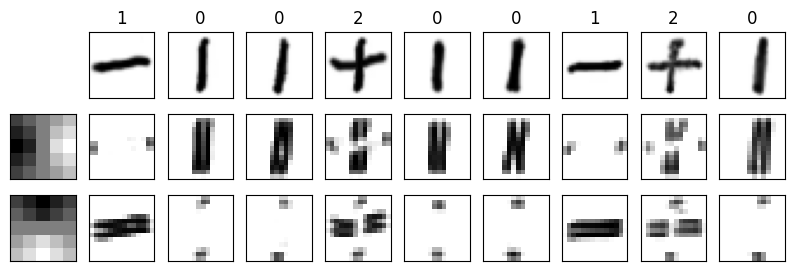

In [9]:
fig = plt.figure(figsize=(10, 3))
filter_vals = edge_filter()
v_max = np.max(pool_output)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28, 28)),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)